# Data exploration

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from cataclop.core.models import *

from cataclop.ml.preprocessing import append_hist, model_to_dict

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
from django.db.models import Max, Min

Race.objects.all().aggregate(Max('start_at'), Min('start_at'))

{'start_at__max': datetime.datetime(2021, 1, 31, 17, 47),
 'start_at__min': datetime.datetime(2021, 1, 1, 11, 50)}

In [3]:
hippos = Hippodrome.objects.all()
hippos = [ model_to_dict(hippo) for hippo in hippos ]
hippos_df = pd.DataFrame.from_records(hippos, index="id")
hippos_df.index.name = "hippodrome_id"

for c in ["country"]:
    hippos_df[c] = hippos_df[c].astype("category")

### Hippodromes / country

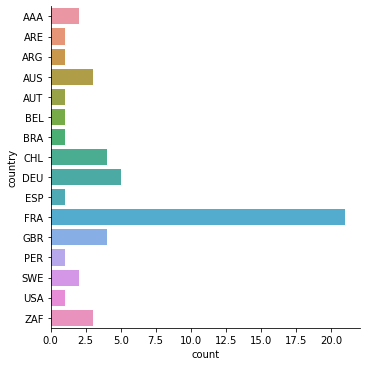

In [4]:
sns.catplot(y="country", kind="count", data=hippos_df)

In [5]:
races = Race.objects.all().prefetch_related("player_set", "session")

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

sessions_df = pd.DataFrame.from_records(sessions, index="id")
sessions_df.index.name = "session_id"
sessions_df = sessions_df.join(hippos_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")

players = [ model_to_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]
races_df = pd.DataFrame.from_records(races, index="id")
races_df.index.name = "race_id"
races_df["start_at"] = pd.to_datetime(races_df["start_at"])

races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")
races_df["date"] = pd.to_datetime(races_df["date"])

for c in ["category", "condition_age", "condition_sex", "sub_category"]:
    races_df[c] = races_df[c].astype("category")

In [6]:
races_df.columns

Index(['imported_at', 'start_at', 'num_race', 'num_bis', 'category',
       'sub_category', 'condition_age', 'condition_sex', 'prize', 'distance',
       'declared_player_count', 'session_id', 'imported_at_session',
       'num_session', 'date', 'hippodrome_id', 'imported_at_hippo', 'code',
       'name', 'country'],
      dtype='object')

### Races / country

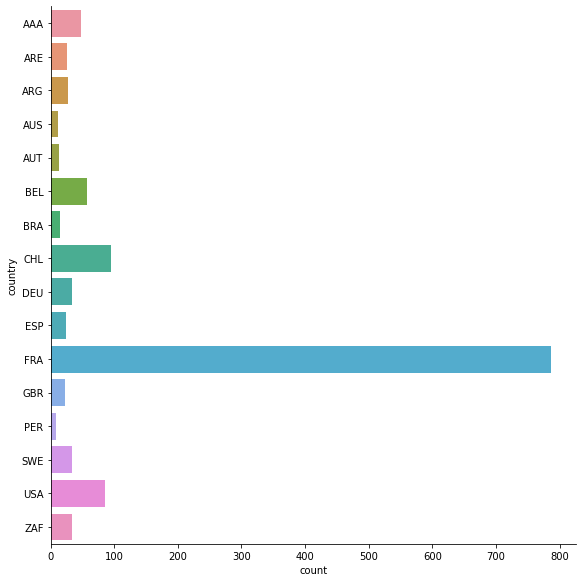

In [7]:
sns.catplot(y="country", kind="count", data=races_df, height=8)

### Races / type

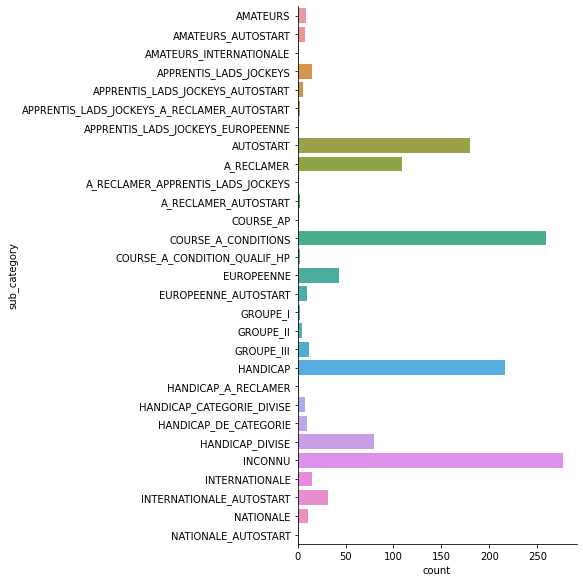

In [8]:
sns.catplot(y="sub_category", kind="count", data=races_df, height=8)

### Evolution of #races for main categories

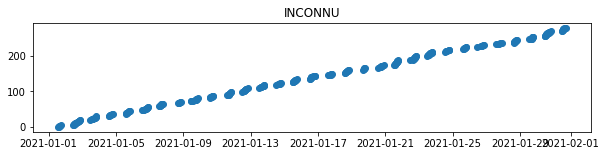

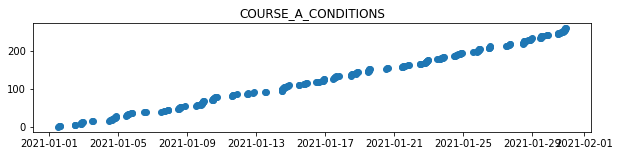

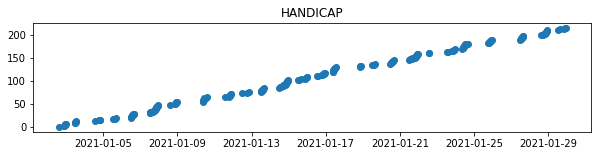

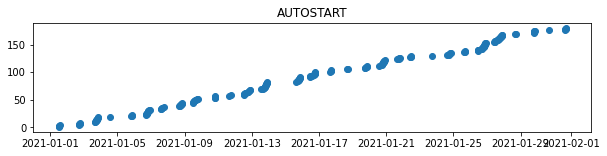

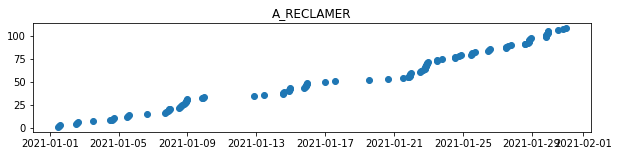

In [9]:
for cat in list(races_df['sub_category'].value_counts().index[0:5]):
    r = races_df[races_df['sub_category']==cat].sort_values(by='start_at', ascending=True)
    r['one'] = 1
    r['races_before'] = r['one'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_title(cat)
    ax.plot_date(r['start_at'], r['races_before'])
    plt.show()

### Prize log distribution

/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='prize', ylabel='Density'>

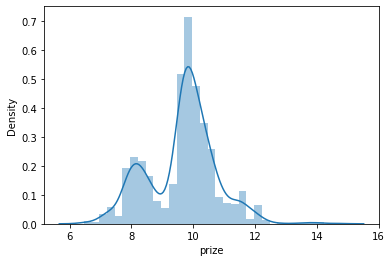

In [10]:
sns.distplot(np.log(races_df['prize']+1))

### #runner distribution

/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='declared_player_count'>

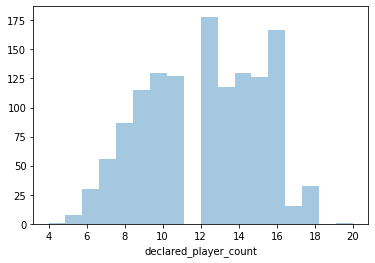

In [11]:
sns.distplot(races_df['declared_player_count'], kde=False)

### Races / hippodromes

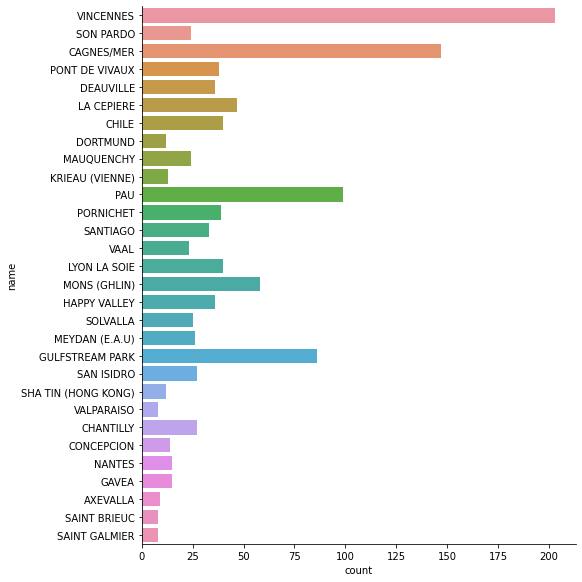

In [12]:
main_hippos = list(races_df['name'].value_counts()[0:30].index)
sns.catplot(y="name", kind="count", data=races_df[(races_df['name'].isin(main_hippos))], height=8)

In [13]:
df = pd.DataFrame.from_records(players, index="id")
df = df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")

In [14]:
df['winner_dividend'] /= 100.
df[df['position']==1][['winner_dividend', 'final_odds_unibet', 'final_odds_ref', 'final_odds_ref_unibet']].describe()

,winner_dividend,final_odds_unibet,final_odds_ref,final_odds_ref_unibet
count,1273.000000,1305.000000,1276.000000,1305.000000
mean,8.831422,8.742912,8.796395,9.882912
std,11.591026,11.646275,8.919312,14.615111
min,1.100000,1.100000,1.100000,1.100000
25%,3.100000,2.900000,3.700000,3.300000
50%,5.300000,5.100000,6.400000,6.000000
75%,9.800000,9.600000,10.000000,11.200000
max,140.400000,140.700000,113.000000,253.600000


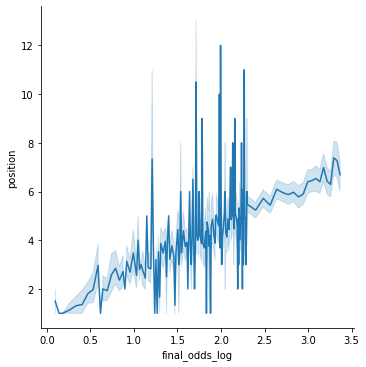

In [15]:
df['final_odds_log'] = np.log(df['final_odds'])
sns.relplot(x="final_odds_log", y="position", kind="line", data=df[df['final_odds']<30])

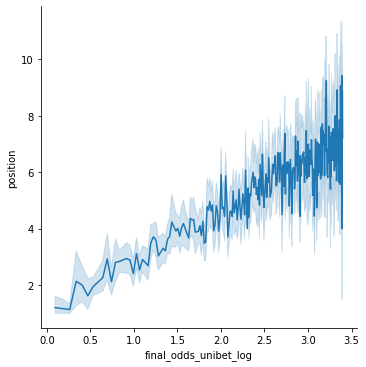

In [16]:
df['final_odds_unibet_log'] = np.log(df['final_odds_unibet'])
sns.relplot(x="final_odds_unibet_log", y="position", kind="line", data=df[df['final_odds_unibet']<30])

In [17]:
from django.db.models import Avg, Count, Sum, Q, Max
print(Odds.objects.filter(is_final=True).aggregate(Avg('value')))
print(Odds.objects.filter(is_final_ref=True).aggregate(Avg('value')))

{'value__avg': 33.77956326987686}
{'value__avg': 23.497622361837383}


### winning amount / category

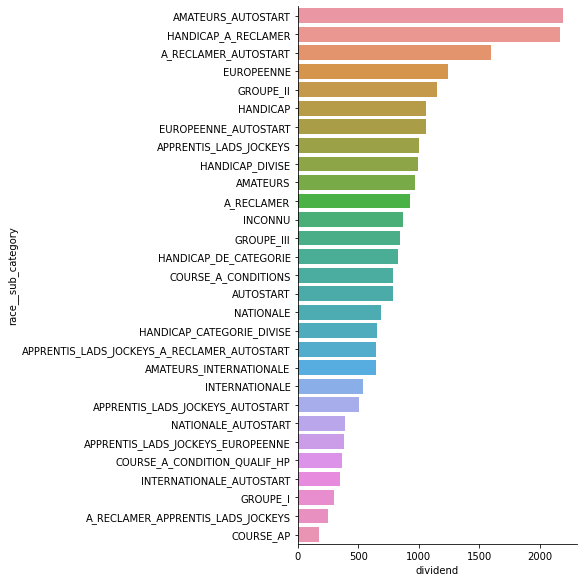

In [18]:
dividend_per_cat = list(Player.objects.filter(winner_dividend__isnull=False)\
     .values('race__sub_category')\
     .annotate(dividend=Avg('winner_dividend'))\
     .order_by('-dividend'))
df = pd.DataFrame.from_records(dividend_per_cat)

sns.catplot(y="race__sub_category", x="dividend", kind="bar", data=df, height=8)

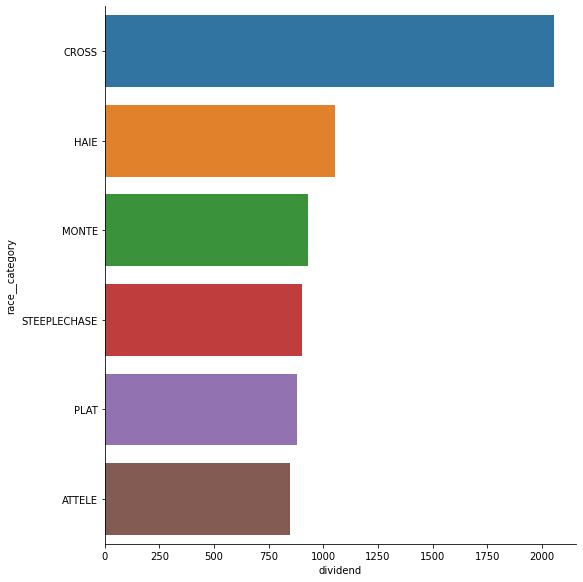

In [20]:
dividend_per_cat = list(Player.objects.filter(winner_dividend__isnull=False)\
     .values('race__category')\
     .annotate(dividend=Avg('winner_dividend'))\
     .order_by('-dividend'))
df = pd.DataFrame.from_records(dividend_per_cat)

sns.catplot(y="race__category", x="dividend", kind="bar", data=df, height=8)

In [21]:
from datetime import datetime, timedelta

after = datetime.strptime('2019-01-01', '%Y-%m-%d')

race = Race.objects.filter(imported_at__gt=after).order_by('?').first()

print(race, race.sub_category)

print(race.player_set.aggregate(dividend=Max('winner_dividend'))['dividend']/100.0)
for p in race.player_set.order_by('position'):
    print(p, p.music, p.position, p.post_position, p.winner_dividend)
    print([(o.date.strftime('%H:%M:%S'), o.value, o.evolution, o.offline) for o in p.odds_set.filter(is_final=False).order_by('date')])

2021-01-25 R4C2 16:25 INCONNU
7.5
#1 (13.0) - FITNA BOCAIN (20)2aDaDaRaDa(19)Da7a0a None 1 None
[('15:50:05', 13.0, -10.27, False), ('15:50:05', 15.0, 6.2, True)]
#2 (18.0) - FANTASIA DUEM 7a(20)4aDa7a7a6a8aDa4a None 2 None
[('15:50:05', 18.0, 9.81, False), ('15:50:05', 19.0, 1.43, True)]
#10 (14.0) - FELICIA DE FORGES 4m(20)0a6m5m6a2a9a9a7a None 10 None
[('15:50:05', 14.0, 10.74, False), ('15:50:05', 18.0, 10.65, True)]
#14 (10.0) - ELYSA DES CAUX 8a(20)0a0aDaDa4a5a6a5a 1 14 750
[('15:50:05', 10.0, 6.48, False), ('15:50:05', 9.7, 0.0, True)]
#4 (9.5) - FILLE D'ARGENT Dm(20)7m3a0a5a7aDaDa4a 2 4 None
[('15:50:05', 9.5, 11.25, False), ('15:50:05', 12.0, 3.27, True)]
#6 (4.5) - FOLIE DE BOURGOGNE Da(20)Da0a0a4a0a1a2aDa 3 6 None
[('15:50:05', 4.5, 8.88, False), ('15:50:05', 7.4, 5.88, True)]
#7 (24.0) - EGERIE DU PUY (20)6a4a8aDa2a4a7aDa6a 4 7 None
[('15:50:05', 24.0, -1.7, False), ('15:50:05', 12.0, 5.93, True)]
#13 (34.0) - EMERAUDE DE BOUGY 6mDa(20)0a0aDa9a1a5a4a 5 13 None
[('15:50:05',

### min/max odds, # of player and winning amount relation

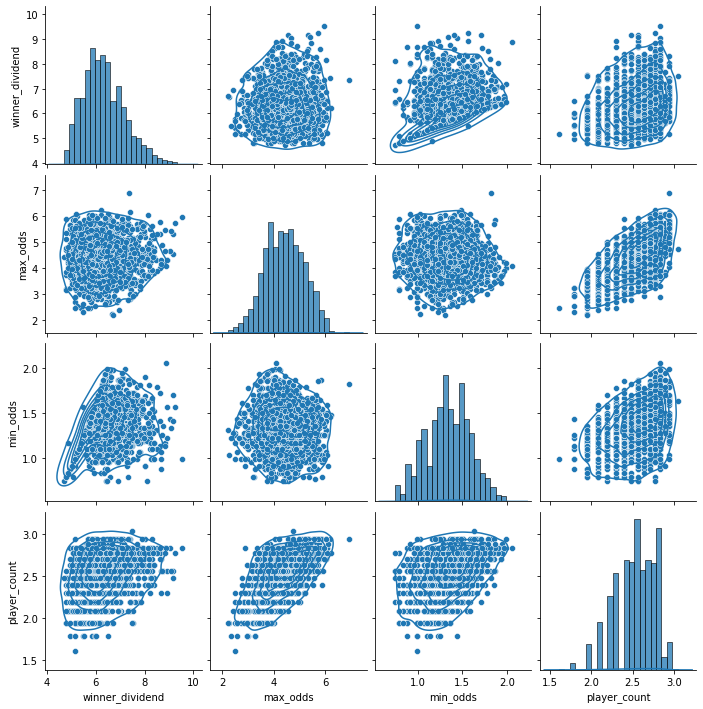

In [22]:
races = Race.objects\
  .annotate(winner_dividend=Max('player__winner_dividend'), \
            max_odds=Max('player__final_odds'), \
            min_odds=Min('player__final_odds'), \
            player_count=Count('player__id')) \
  .values('winner_dividend', 'min_odds', 'max_odds', 'player_count')

df = pd.DataFrame.from_records(list(races))
df = df+1.
df = np.log(df)
g = sns.pairplot(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)
